<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_keras_classification_model_vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependency

In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.78 s (started: 2021-07-22 22:39:23 +00:00)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 6.09 ms (started: 2021-07-22 22:39:26 +00:00)


In [ ]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0
time: 2.88 ms (started: 2021-07-22 22:39:26 +00:00)


# Load and preview Data

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_train_all = x_train_all / 255.0
x_test = x_test / 255.0

# 从training set拆分出val set
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
time: 615 ms (started: 2021-07-22 22:39:26 +00:00)


In [ ]:
#x_train[0]

time: 1.11 ms (started: 2021-07-22 22:39:26 +00:00)


In [ ]:
print(np.max(x_train), np.min(x_train))

1.0 0.0
time: 65.1 ms (started: 2021-07-22 22:39:26 +00:00)


## Standardization 数据归一化/标准化

training, val和testing都需要归一化，但是都是以training的mean，std为基准

下面会用到`Batch Normalization`，就是layers每一层都会要normalization一次

In [ ]:
# x = (x-u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# x_train: [None, 28, 28] -> [None, 784] -> transform ->  [None, 28, 28]
# 每张图片先flatten到一维，归一化，再转回二维
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)   

# val和testing set直接用training set的均值和方差，所以不用fit_transform, 直接fit
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

time: 854 ms (started: 2021-07-22 22:39:26 +00:00)


In [ ]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105137
time: 42.6 ms (started: 2021-07-22 22:39:27 +00:00)


In [ ]:
# 只有一个通道的28*28黑白图片
x_train[0].shape

(28, 28)

time: 5.2 ms (started: 2021-07-22 22:39:27 +00:00)


In [ ]:
#x_train[0]

time: 1.23 ms (started: 2021-07-22 22:39:27 +00:00)


In [ ]:
#y_train

time: 1.15 ms (started: 2021-07-22 22:39:27 +00:00)


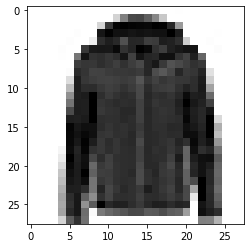

time: 179 ms (started: 2021-07-22 22:39:27 +00:00)


In [ ]:
def show_single_image(img_arr):

  # imshow可以直接打印图片
  plt.imshow(img_arr, cmap= 'binary', interpolation='nearest')
  plt.show()

show_single_image(x_train[0])

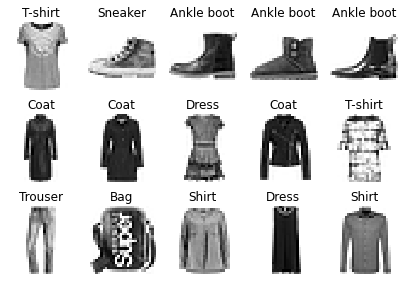

time: 496 ms (started: 2021-07-22 22:39:27 +00:00)


In [ ]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col + 1
            plt.subplot(n_rows, n_cols, index)
            plt.imshow(x_data[index], cmap='binary', interpolation='nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=[28,28]))
# model.output_shape

time: 2.74 ms (started: 2021-07-22 22:39:28 +00:00)


# Training

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 17.1 ms (started: 2021-07-22 22:39:28 +00:00)


In [ ]:
# tf.keras.Sequential()

'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
'''

model = keras.models.Sequential([
     
    keras.layers.Flatten(input_shape=[28,28]),    # 将28*28input压扁成一维向量1*728
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # 最后一层输出为1*10的向量 

])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[]
model.compile(loss='sparse_categorical_crossentropy',    # 之所以使用sparse_categorical_crossentropy是因为我们的y是[1, 2]这样的向量，而不是one hot，但是我们的模型输出是[[0.05, 0.95, 0], [0.1, 0.8, 0.1]]这样的one hot
              #optimizer='sgd',
              optimizer = 'adam',
              metrics=['accuracy', 
                       f1_m, 
                       precision_m, 
                       recall_m
                       ]
              )

time: 51.5 ms (started: 2021-07-22 22:39:28 +00:00)


In [ ]:
model.layers

time: 4.07 ms (started: 2021-07-22 22:39:28 +00:00)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
time: 6.38 ms (started: 2021-07-22 22:39:28 +00:00)


In [ ]:
# 参数量w, b的由来
# [None, 784] * W + b -> [None, 300]
# W.shape = [784 * 300], b.shape = [300]

784*300+300

235500

time: 10 ms (started: 2021-07-22 22:39:28 +00:00)


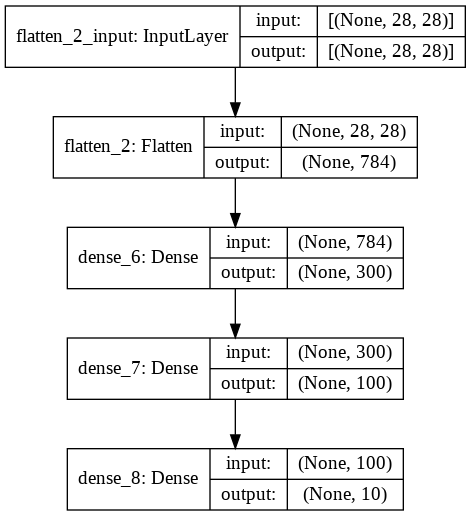

time: 143 ms (started: 2021-07-22 22:39:28 +00:00)


In [ ]:
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       #rankdir="LR"
                       )

## Callbacks

Callbacks主要是训练模型途中的一些自动化操作，最常用的一些callbacks有：
1. tensorboard  即时显示训练情况  
2. earlystopping 早停法
3. modelcheckpoint  保存(最优)模型

运行TensorBoard的方法：
在有`callbacks`文件的目录下运行


    tenforboard --logdir=callbacks

In [ ]:
# 结果一般都是保存着history这个变量里面
# 加入三种最常用的callbacks：tensorboard，earlystopping，modelcheckpoint

logdir = '/content/callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)

output_model_file = os.path.join(logdir, 
                                 "fashion_mnist_model.h5")

callbacks = [
             keras.callbacks.TensorBoard(logdir),  # 将TensorBoard文件存在callbacks folder
             keras.callbacks.ModelCheckpoint(output_model_file,   # 将模型存在h5 file
                                             save_best_only = True),
             keras.callbacks.EarlyStopping(patience = 5,  # 设置早停
                                           min_delta = 1e-3 
             )
             
]

history = model.fit(
    x_train_scaled, 
    y_train, 
    epochs=10, 
    validation_data=(x_valid_scaled, y_valid),
    callbacks = callbacks,
    verbose=1   # 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    )

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4612 - accuracy: 0.8327 - f1_m: 1.4052 - precision_m: 1.4526 - recall_m: 1.4159 - val_loss: 0.3798 - val_accuracy: 0.8630 - val_f1_m: 1.2952 - val_precision_m: 1.2698 - val_recall_m: 1.3250
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3545 - accuracy: 0.8680 - f1_m: 1.2926 - precision_m: 1.2640 - recall_m: 1.3261 - val_loss: 0.3388 - val_accuracy: 0.8800 - val_f1_m: 1.2616 - val_precision_m: 1.2414 - val_recall_m: 1.2852
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3179 - accuracy: 0.8819 - f1_m: 1.2547 - precision_m: 1.2218 - recall_m: 1.2927 - val_loss: 0.3477 - val_accuracy: 0.8706 - val_f1_m: 1.2435 - val_precision_m: 1.2137 - val_recall_m: 1.2779
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2921 - accuracy: 0.8911 - f1_m: 1.2275 - precision_m: 1.1910 - recall_m: 1.2693 - val_loss: 0.3542 - val_accuracy: 0.8

In [ ]:
ls

callbacks/  model.png  sample_data/
time: 159 ms (started: 2021-07-22 22:40:37 +00:00)


In [ ]:
# 启动tensorboard

#%tensorboard --logdir=callbacks

time: 1.67 ms (started: 2021-07-22 22:40:37 +00:00)


In [ ]:
type(history) # history其实是一个callback

tensorflow.python.keras.callbacks.History

time: 6.64 ms (started: 2021-07-22 22:40:37 +00:00)


In [ ]:
history.epoch

history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

time: 6.33 ms (started: 2021-07-22 22:40:37 +00:00)


In [ ]:
history.history

{'accuracy': [0.8327272534370422,
  0.8680363893508911,
  0.8819090723991394,
  0.8911454677581787,
  0.8978182077407837,
  0.9044363498687744,
  0.9082182049751282,
  0.9139272570610046,
  0.9169999957084656,
  0.9225999712944031],
 'f1_m': [1.4052306413650513,
  1.2925975322723389,
  1.2546721696853638,
  1.227461338043213,
  1.2042847871780396,
  1.1910597085952759,
  1.1772072315216064,
  1.1624103784561157,
  1.1536099910736084,
  1.1389849185943604],
 'loss': [0.4611753225326538,
  0.35448846220970154,
  0.3178909420967102,
  0.29209762811660767,
  0.2722441852092743,
  0.2559114992618561,
  0.24371638894081116,
  0.22724726796150208,
  0.21732576191425323,
  0.2062775194644928],
 'precision_m': [1.4526435136795044,
  1.2639986276626587,
  1.2218360900878906,
  1.1910390853881836,
  1.165610432624817,
  1.1501110792160034,
  1.1351675987243652,
  1.1194499731063843,
  1.1098688840866089,
  1.094285249710083],
 'recall_m': [1.4159126281738281,
  1.3261393308639526,
  1.29273474216

time: 10.2 ms (started: 2021-07-22 22:40:37 +00:00)


# Plot Validation 

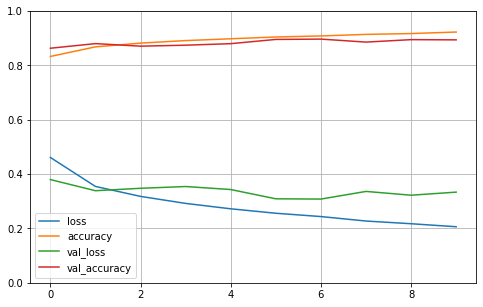

time: 222 ms (started: 2021-07-22 22:40:37 +00:00)


In [ ]:
def plot_learning_curves(history):

    # 选择需要plot的metrics，否则变量太多了
    plot_metrics = {k:v for k,v in history.history.items() if k in ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

    pd.DataFrame(plot_metrics).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
 model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3412 - accuracy: 0.8876 - f1_m: 1.1522 - precision_m: 1.1088 - recall_m: 1.2015


[0.34120577573776245,
 0.8876000046730042,
 1.15218186378479,
 1.1087666749954224,
 1.201465368270874]

time: 1.14 s (started: 2021-07-22 22:40:37 +00:00)
